# Project: PolBlogs

### **PolBlogs (Political Blogs)**:
+ Граф блогов, собранный в 2005 году, где узлы — это блоги, а рёбра — гиперссылки между ними.
+ Узлы имеют классы, указывающие на политическую принадлежность ("левые" или "правые").
+ Задача: классификация вершин.

In [ ]:
!pip install torch-geometric

#### Dataset

Выполним загрузку и анализ датасета

In [3]:
import torch
from torch_geometric.datasets import PolBlogs
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader

dataset = PolBlogs(root="data/PolBlogs")

data = dataset[0]

print("Граф содержит:")
print(f"- Узлов: {data.num_nodes}")
print(f"- Ребер: {data.num_edges}")
print(f"- Количество признаков на узел: {data.num_node_features}")
print(f"- Количество классов: {dataset.num_classes}")
print(f"- Узлы с классами: {data.y.unique().tolist()}")
print(data)

Extracting data/PolBlogs/raw/polblogs.tar.gz
Processing...


Граф содержит:
- Узлов: 1490
- Ребер: 19025
- Количество признаков на узел: 0
- Количество классов: 2
- Узлы с классами: [0, 1]
Data(edge_index=[2, 19025], y=[1490], num_nodes=1490)


Done!


Выполним визуализацию графа

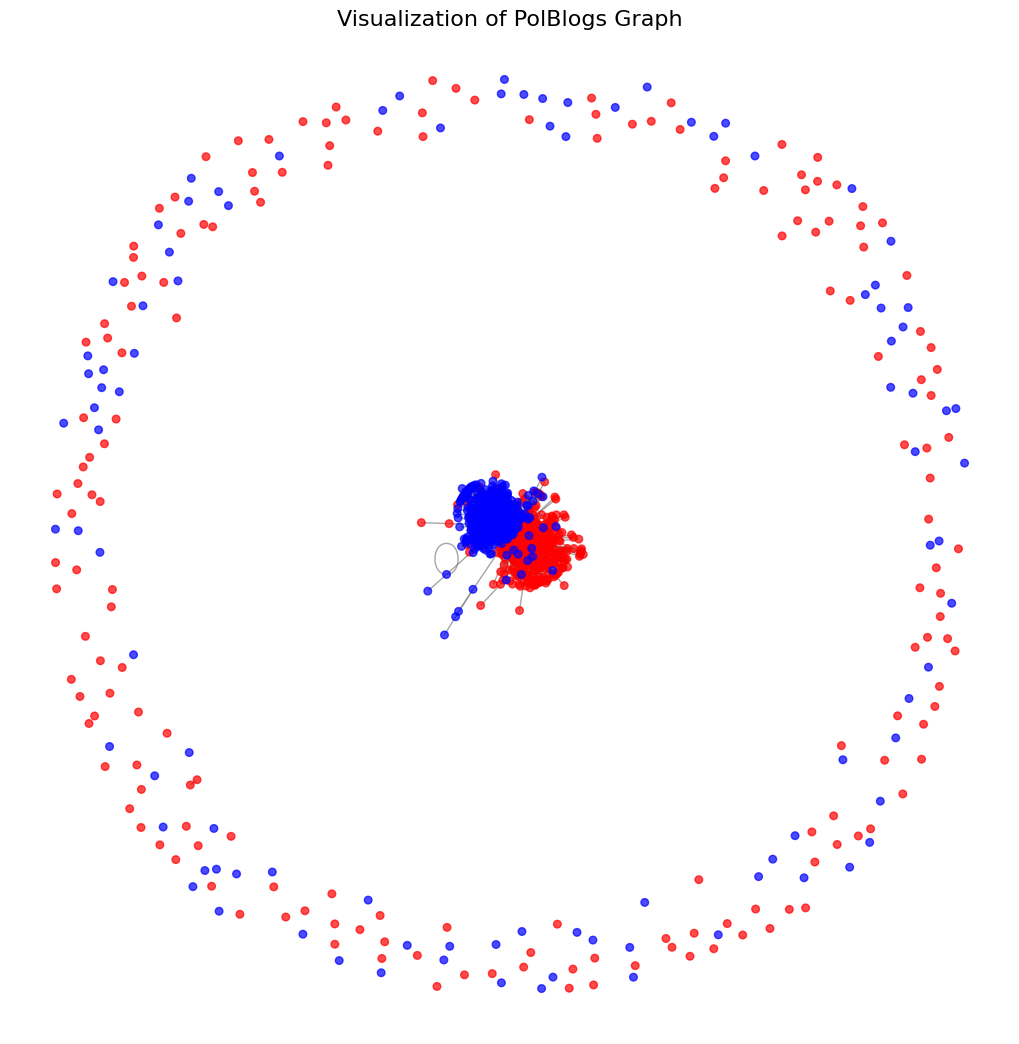

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx


G = to_networkx(data, to_undirected=True)
node_labels = data.y.numpy()
color_map = ['red' if label == 0 else 'blue' for label in node_labels]

plt.figure(figsize=(10, 10))
nx.draw(
    G,
    node_color=color_map,
    with_labels=False,
    node_size=30,
    edge_color="gray",
    alpha=0.7,
)
plt.title("Visualization of PolBlogs Graph", fontsize=16)
plt.show()

Убирем вершины без ребер

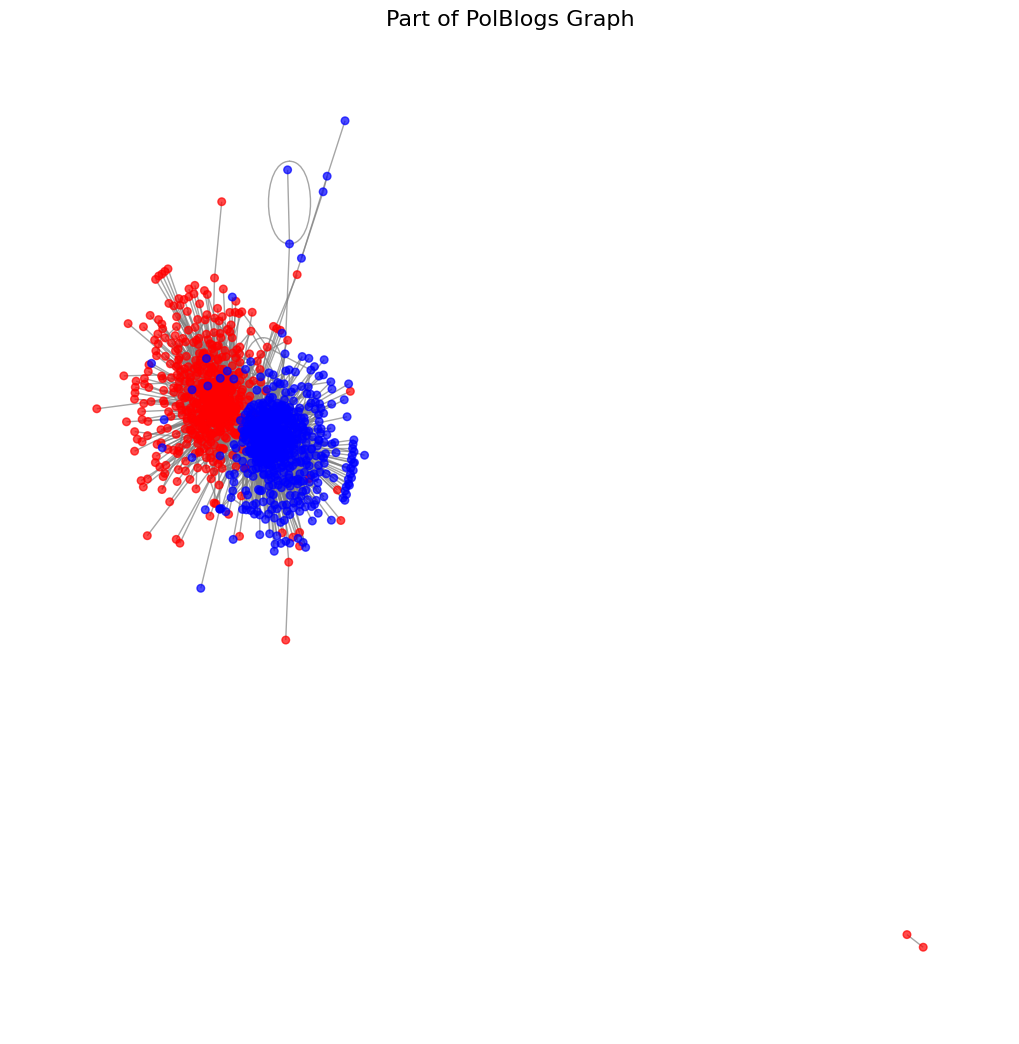

In [5]:
G = to_networkx(data, to_undirected=True)
nodes_with_edges = [node for node, degree in dict(G.degree()).items() if degree > 0]
G_central = G.subgraph(nodes_with_edges)
node_labels_central = data.y[nodes_with_edges].numpy()
color_map_central = ['red' if label == 0 else 'blue' for label in node_labels_central]

plt.figure(figsize=(10, 10))
nx.draw(
    G_central,
    node_color=color_map_central,
    with_labels=False,
    node_size=30,
    edge_color="gray",
    alpha=0.7,
)
plt.title("Part of PolBlogs Graph", fontsize=16)
plt.show()

Раздилим датасет

In [6]:
import torch
from sklearn.model_selection import train_test_split


nodes = torch.arange(data.num_nodes)
labels = data.y

train_nodes, temp_nodes, train_labels, temp_labels = train_test_split(
    nodes, labels, test_size=0.4, stratify=labels, random_state=42
)

val_nodes, test_nodes, val_labels, test_labels = train_test_split(
    temp_nodes, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[train_nodes] = True
val_mask[val_nodes] = True
test_mask[test_nodes] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(f"Train set size: {train_mask.sum().item()}")
print(f"Validation set size: {val_mask.sum().item()}")
print(f"Test set size: {test_mask.sum().item()}")

Train set size: 894
Validation set size: 298
Test set size: 298


#### Models

Построим GCN модель

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [8]:
hidden_dim = 16
input_dim = 1
output_dim = 2

data.x = torch.ones((data.num_nodes, input_dim))
model = GCN(input_dim, hidden_dim, output_dim)
print(model)

GCN(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 2)
)


In [9]:
class_counts = torch.bincount(data.y)
class_weights = 1.0 / class_counts.float()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def evaluate(data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out[mask].max(dim=1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    return acc

In [10]:
num_epochs = 200
train_losses = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    loss = train(data)
    train_losses.append(loss)

    val_acc = evaluate(data, data.val_mask)
    val_accuracies.append(val_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch: 001, Loss: 0.7070, Validation Accuracy: 0.5067
Epoch: 010, Loss: 0.6920, Validation Accuracy: 0.4966
Epoch: 020, Loss: 0.6921, Validation Accuracy: 0.5336
Epoch: 030, Loss: 0.6921, Validation Accuracy: 0.5034
Epoch: 040, Loss: 0.6918, Validation Accuracy: 0.5604
Epoch: 050, Loss: 0.6917, Validation Accuracy: 0.4765
Epoch: 060, Loss: 0.6916, Validation Accuracy: 0.5369
Epoch: 070, Loss: 0.6915, Validation Accuracy: 0.5302
Epoch: 080, Loss: 0.6903, Validation Accuracy: 0.4664
Epoch: 090, Loss: 0.6872, Validation Accuracy: 0.5805
Epoch: 100, Loss: 0.6803, Validation Accuracy: 0.6074
Epoch: 110, Loss: 0.6694, Validation Accuracy: 0.6409
Epoch: 120, Loss: 0.6567, Validation Accuracy: 0.6544
Epoch: 130, Loss: 0.6444, Validation Accuracy: 0.6577
Epoch: 140, Loss: 0.6336, Validation Accuracy: 0.6678
Epoch: 150, Loss: 0.6245, Validation Accuracy: 0.6812
Epoch: 160, Loss: 0.6172, Validation Accuracy: 0.6846
Epoch: 170, Loss: 0.6118, Validation Accuracy: 0.6946
Epoch: 180, Loss: 0.6074, Va

In [11]:
test_acc = evaluate(data, data.test_mask)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6812


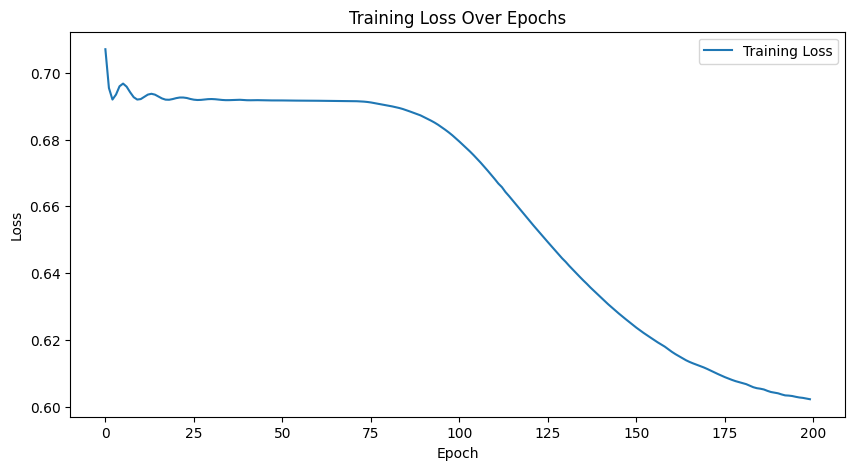

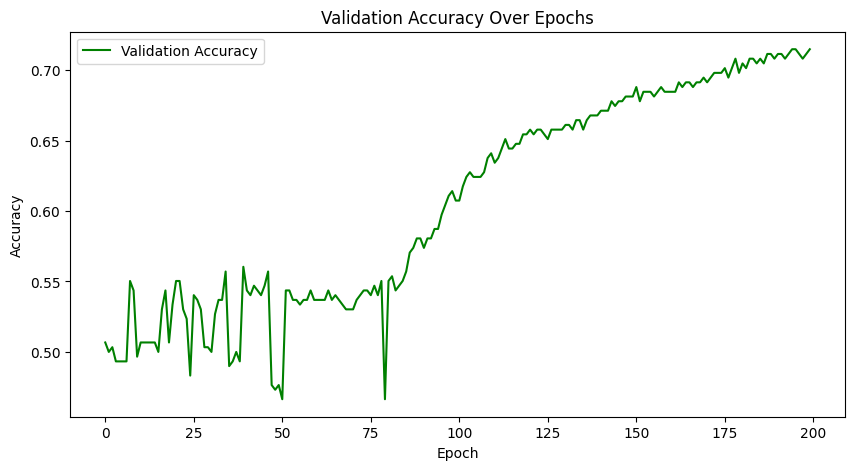

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.show()

Построим GAT модель

In [13]:
import torch
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=1):
        super(GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = torch.relu(x)
        x = self.gat2(x, edge_index)
        return torch.log_softmax(x, dim=1)

In [14]:
hidden_dim = 16
input_dim = 1
output_dim = dataset.num_classes
num_heads = 2

data.x = torch.ones((data.num_nodes, input_dim))
gat_model = GAT(input_dim, hidden_dim, output_dim, heads=num_heads)
print(gat_model)

GAT(
  (gat1): GATConv(1, 16, heads=2)
  (gat2): GATConv(32, 2, heads=1)
)


In [15]:
class_weights = 1.0 / class_counts.float()
criterion = torch.nn.NLLLoss(weight=class_weights)
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01)

def train_gat(data):
    gat_model.train()
    optimizer.zero_grad()
    out = gat_model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_gat(data, mask):
    gat_model.eval()
    with torch.no_grad():
        out = gat_model(data)
        pred = out[mask].max(dim=1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    return acc

In [16]:
num_epochs = 200
gat_train_losses = []
gat_val_accuracies = []

for epoch in range(1, num_epochs + 1):
    loss = train_gat(data)
    gat_train_losses.append(loss)

    val_acc = evaluate_gat(data, data.val_mask)
    gat_val_accuracies.append(val_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch: 001, Loss: 0.7161, Validation Accuracy: 0.5067
Epoch: 010, Loss: 0.6938, Validation Accuracy: 0.4933
Epoch: 020, Loss: 0.6933, Validation Accuracy: 0.5067
Epoch: 030, Loss: 0.6932, Validation Accuracy: 0.5067
Epoch: 040, Loss: 0.6932, Validation Accuracy: 0.4933
Epoch: 050, Loss: 0.6931, Validation Accuracy: 0.5067
Epoch: 060, Loss: 0.6931, Validation Accuracy: 0.4933
Epoch: 070, Loss: 0.6932, Validation Accuracy: 0.5067
Epoch: 080, Loss: 0.6931, Validation Accuracy: 0.4933
Epoch: 090, Loss: 0.6931, Validation Accuracy: 0.5067
Epoch: 100, Loss: 0.6931, Validation Accuracy: 0.5067
Epoch: 110, Loss: 0.6931, Validation Accuracy: 0.4933
Epoch: 120, Loss: 0.6931, Validation Accuracy: 0.5067
Epoch: 130, Loss: 0.6931, Validation Accuracy: 0.5067
Epoch: 140, Loss: 0.6931, Validation Accuracy: 0.5067
Epoch: 150, Loss: 0.6931, Validation Accuracy: 0.5067
Epoch: 160, Loss: 0.6931, Validation Accuracy: 0.5067
Epoch: 170, Loss: 0.6931, Validation Accuracy: 0.5067
Epoch: 180, Loss: 0.6931, Va

In [17]:
gat_test_acc = evaluate_gat(data, data.test_mask)
print(f"Test Accuracy (GAT): {gat_test_acc:.4f}")

Test Accuracy (GAT): 0.5101


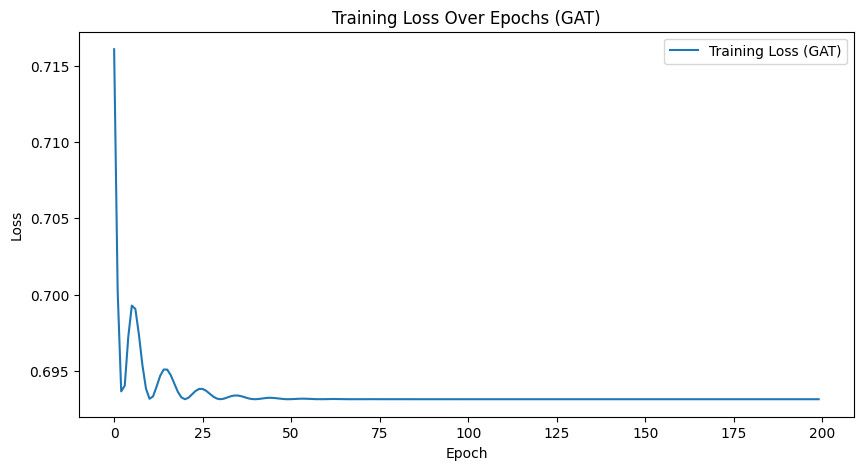

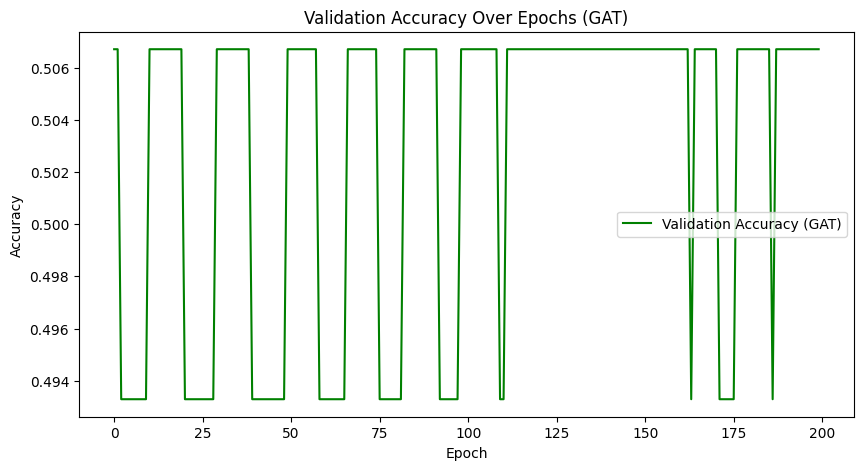

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(gat_train_losses, label="Training Loss (GAT)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs (GAT)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(gat_val_accuracies, label="Validation Accuracy (GAT)", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs (GAT)")
plt.legend()
plt.show()

Построим GraphSAGE

In [19]:
from torch_geometric.nn import SAGEConv


class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

In [20]:
hidden_dim = 16
input_dim = data.x.shape[1]
output_dim = 2

sage_model = GraphSAGE(input_dim, hidden_dim, output_dim)
print(sage_model)

GraphSAGE(
  (conv1): SAGEConv(1, 16, aggr=mean)
  (conv2): SAGEConv(16, 2, aggr=mean)
)


In [21]:
class_weights = 1.0 / class_counts.float()
criterion = torch.nn.NLLLoss(weight=class_weights)
optimizer = torch.optim.Adam(sage_model.parameters(), lr=0.001, weight_decay=5e-4)

def train_sage(data):
    sage_model.train()
    optimizer.zero_grad()
    out = sage_model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_sage(data, mask):
    sage_model.eval()
    with torch.no_grad():
        out = sage_model(data)
        pred = out[mask].max(dim=1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    return acc

In [22]:
num_epochs = 200
sage_train_losses = []
sage_val_accuracies = []

for epoch in range(1, num_epochs + 1):
    loss = train_sage(data)
    sage_train_losses.append(loss)

    val_acc = evaluate_sage(data, data.val_mask)
    sage_val_accuracies.append(val_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch: 001, Loss: 0.7186, Validation Accuracy: 0.5067
Epoch: 010, Loss: 0.6958, Validation Accuracy: 0.5067
Epoch: 020, Loss: 0.6846, Validation Accuracy: 0.5772
Epoch: 030, Loss: 0.6819, Validation Accuracy: 0.5772
Epoch: 040, Loss: 0.6810, Validation Accuracy: 0.5772
Epoch: 050, Loss: 0.6801, Validation Accuracy: 0.5772
Epoch: 060, Loss: 0.6795, Validation Accuracy: 0.5772
Epoch: 070, Loss: 0.6792, Validation Accuracy: 0.5772
Epoch: 080, Loss: 0.6790, Validation Accuracy: 0.5772
Epoch: 090, Loss: 0.6787, Validation Accuracy: 0.5772
Epoch: 100, Loss: 0.6785, Validation Accuracy: 0.5772
Epoch: 110, Loss: 0.6783, Validation Accuracy: 0.5839
Epoch: 120, Loss: 0.6781, Validation Accuracy: 0.5839
Epoch: 130, Loss: 0.6779, Validation Accuracy: 0.5839
Epoch: 140, Loss: 0.6777, Validation Accuracy: 0.5839
Epoch: 150, Loss: 0.6774, Validation Accuracy: 0.5839
Epoch: 160, Loss: 0.6772, Validation Accuracy: 0.5839
Epoch: 170, Loss: 0.6770, Validation Accuracy: 0.5839
Epoch: 180, Loss: 0.6768, Va

In [23]:
sage_test_acc = evaluate_sage(data, data.test_mask)
print(f"Test Accuracy (GraphSAGE): {sage_test_acc:.4f}")

Test Accuracy (GraphSAGE): 0.5537


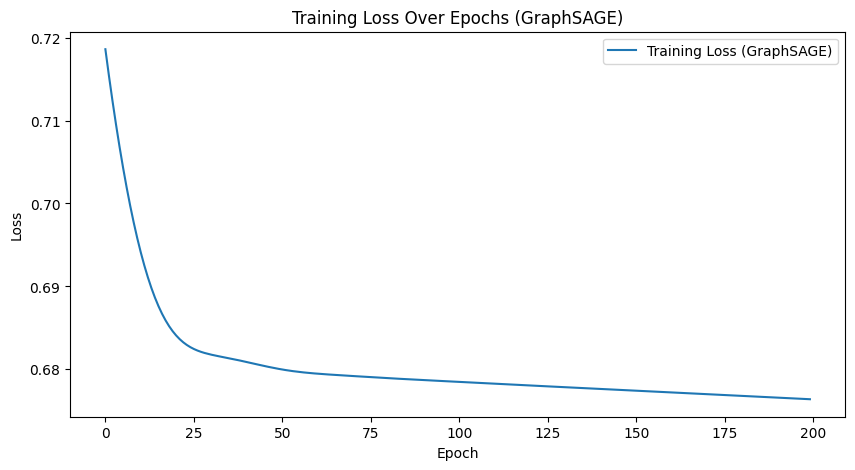

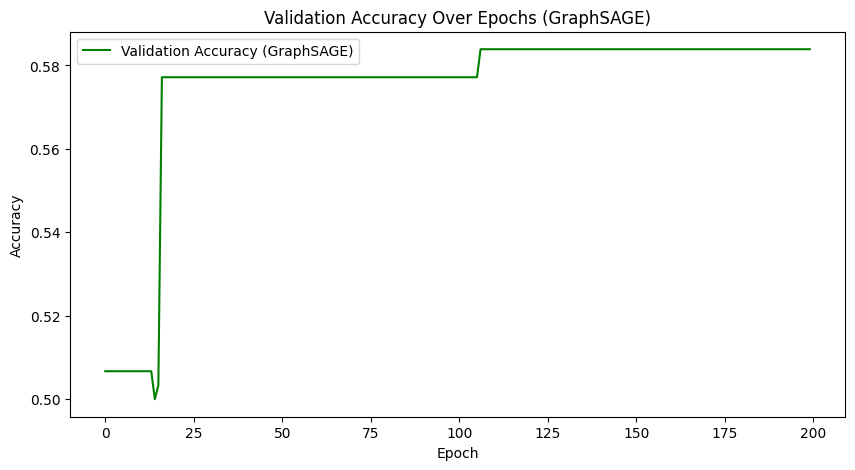

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(sage_train_losses, label="Training Loss (GraphSAGE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs (GraphSAGE)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(sage_val_accuracies, label="Validation Accuracy (GraphSAGE)", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs (GraphSAGE)")
plt.legend()
plt.show()

Построим GIN модель

In [25]:
from torch_geometric.nn import GINConv
from torch.nn import Sequential, Linear, ReLU


class GIN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GIN, self).__init__()
        nn1 = Sequential(Linear(input_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(nn1)
        nn2 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv2 = GINConv(nn2)
        self.classifier = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.classifier(x)
        return torch.log_softmax(x, dim=1)

In [26]:
hidden_dim = 16
input_dim = data.x.shape[1]
output_dim = 2

gin_model = GIN(input_dim, hidden_dim, output_dim)
print(gin_model)

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)


In [27]:
class_weights = 1.0 / class_counts.float()
criterion = torch.nn.NLLLoss(weight=class_weights)
optimizer = torch.optim.Adam(gin_model.parameters(), lr=0.001, weight_decay=5e-4)

def train_gin(data):
    gin_model.train()
    optimizer.zero_grad()
    out = gin_model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_gin(data, mask):
    gin_model.eval()
    with torch.no_grad():
        out = gin_model(data)
        pred = out[mask].max(dim=1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    return acc

In [32]:
num_epochs = 200
gin_train_losses = []
gin_val_accuracies = []

for epoch in range(1, num_epochs + 1):
    loss = train_gin(data)
    gin_train_losses.append(loss)

    val_acc = evaluate_gin(data, data.val_mask)
    gin_val_accuracies.append(val_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch: 001, Loss: 0.6037, Validation Accuracy: 0.7215
Epoch: 010, Loss: 0.6018, Validation Accuracy: 0.7215
Epoch: 020, Loss: 0.5996, Validation Accuracy: 0.7416
Epoch: 030, Loss: 0.5996, Validation Accuracy: 0.7450
Epoch: 040, Loss: 0.5977, Validation Accuracy: 0.7282
Epoch: 050, Loss: 0.5953, Validation Accuracy: 0.7383
Epoch: 060, Loss: 0.5901, Validation Accuracy: 0.7315
Epoch: 070, Loss: 0.5907, Validation Accuracy: 0.7383
Epoch: 080, Loss: 0.5931, Validation Accuracy: 0.7315
Epoch: 090, Loss: 0.5873, Validation Accuracy: 0.7282
Epoch: 100, Loss: 0.5852, Validation Accuracy: 0.7315
Epoch: 110, Loss: 0.5823, Validation Accuracy: 0.7248
Epoch: 120, Loss: 0.5827, Validation Accuracy: 0.7248
Epoch: 130, Loss: 0.5803, Validation Accuracy: 0.7248
Epoch: 140, Loss: 0.5883, Validation Accuracy: 0.7215
Epoch: 150, Loss: 0.5816, Validation Accuracy: 0.7315
Epoch: 160, Loss: 0.5791, Validation Accuracy: 0.7215
Epoch: 170, Loss: 0.5757, Validation Accuracy: 0.7349
Epoch: 180, Loss: 0.5736, Va

In [33]:
gin_test_acc = evaluate_gin(data, data.test_mask)
print(f"Test Accuracy (GIN): {gin_test_acc:.4f}")

Test Accuracy (GIN): 0.7215


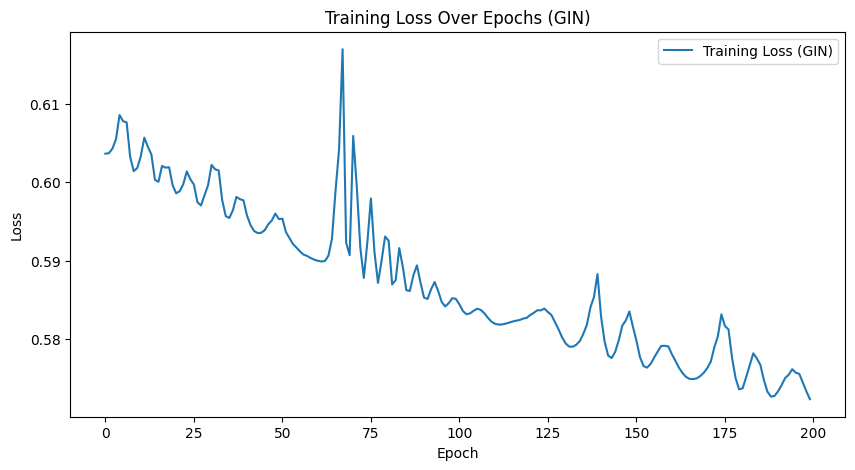

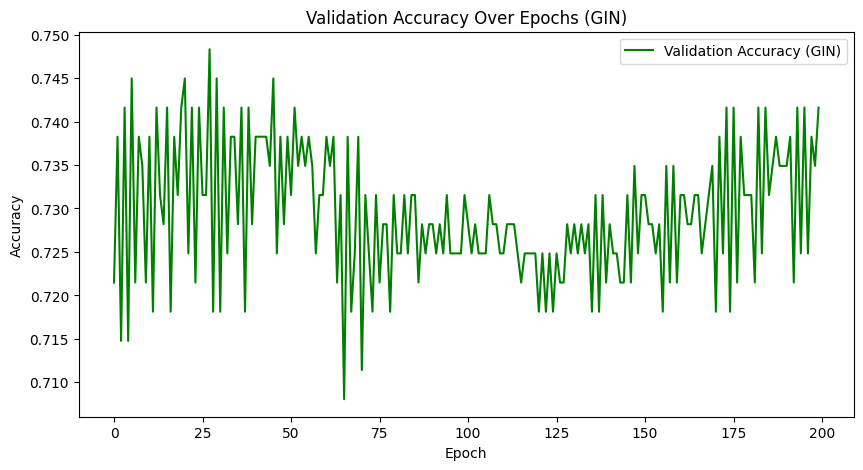

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(gin_train_losses, label="Training Loss (GIN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs (GIN)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(gin_val_accuracies, label="Validation Accuracy (GIN)", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs (GIN)")
plt.legend()
plt.show()

Попробуем DeepWalk и Node2Vec

In [ ]:
!pip install node2vec

Начнем с DeepWalk

In [36]:
import networkx as nx
from node2vec import Node2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
node2vec = Node2Vec(G, dimensions=64, walk_length=10, num_walks=20, workers=4, p=1, q=1)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
node_embeddings = torch.tensor([model.wv[str(node)] for node in range(data.num_nodes)])

Computing transition probabilities:   0%|          | 0/1490 [00:00<?, ?it/s]

<ipython-input-36-ba845fe48712>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  node_embeddings = torch.tensor([model.wv[str(node)] for node in range(data.num_nodes)])


In [ ]:
train_nodes = torch.arange(data.num_nodes)[data.train_mask]
val_nodes = torch.arange(data.num_nodes)[data.val_mask]
test_nodes = torch.arange(data.num_nodes)[data.test_mask]

In [37]:
X_train = node_embeddings[train_nodes].numpy()
y_train = data.y[train_nodes].numpy()
X_val = node_embeddings[val_nodes].numpy()
y_val = data.y[val_nodes].numpy()
X_test = node_embeddings[test_nodes].numpy()
y_test = data.y[test_nodes].numpy()

In [38]:
classifier = LogisticRegression(max_iter=200)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [39]:
y_val_pred = classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
y_test_pred = classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

In [40]:
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.8826
Test Accuracy: 0.9195


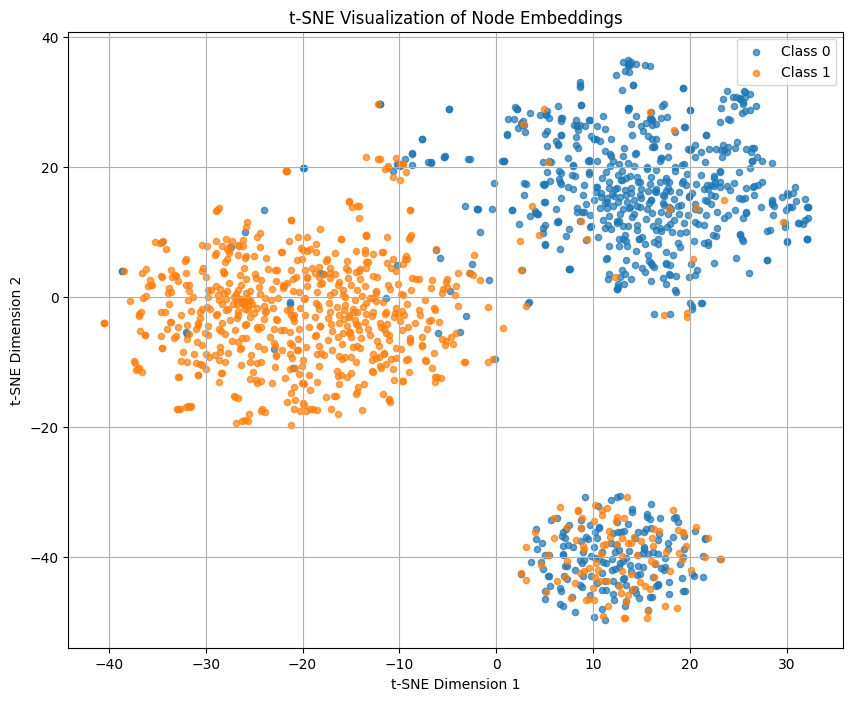

In [41]:
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(node_embeddings.numpy())
labels = data.y.numpy()

plt.figure(figsize=(10, 8))
for class_label in np.unique(labels):
    idx = labels == class_label
    plt.scatter(
        embeddings_2d[idx, 0],
        embeddings_2d[idx, 1],
        label=f"Class {class_label}",
        alpha=0.7,
        s=20
    )

plt.title("t-SNE Visualization of Node Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

Теперь Node2Vec

In [42]:
G = to_networkx(data, to_undirected=True)
node2vec = Node2Vec(
    G,
    dimensions=64,
    walk_length=10,
    num_walks=20,
    workers=4,
    p=0.5,
    q=2.0
)

model = node2vec.fit(window=10, min_count=1, batch_words=4)
node_embeddings = torch.tensor([model.wv[str(node)] for node in range(data.num_nodes)])

Computing transition probabilities:   0%|          | 0/1490 [00:00<?, ?it/s]

In [43]:
train_nodes = torch.arange(data.num_nodes)[data.train_mask]
val_nodes = torch.arange(data.num_nodes)[data.val_mask]
test_nodes = torch.arange(data.num_nodes)[data.test_mask]

In [44]:
X_train = node_embeddings[train_nodes].numpy()
y_train = data.y[train_nodes].numpy()
X_val = node_embeddings[val_nodes].numpy()
y_val = data.y[val_nodes].numpy()
X_test = node_embeddings[test_nodes].numpy()
y_test = data.y[test_nodes].numpy()

In [45]:
classifier = LogisticRegression(max_iter=500)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [46]:
y_val_pred = classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
y_test_pred = classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

In [47]:
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.8826
Test Accuracy: 0.9228


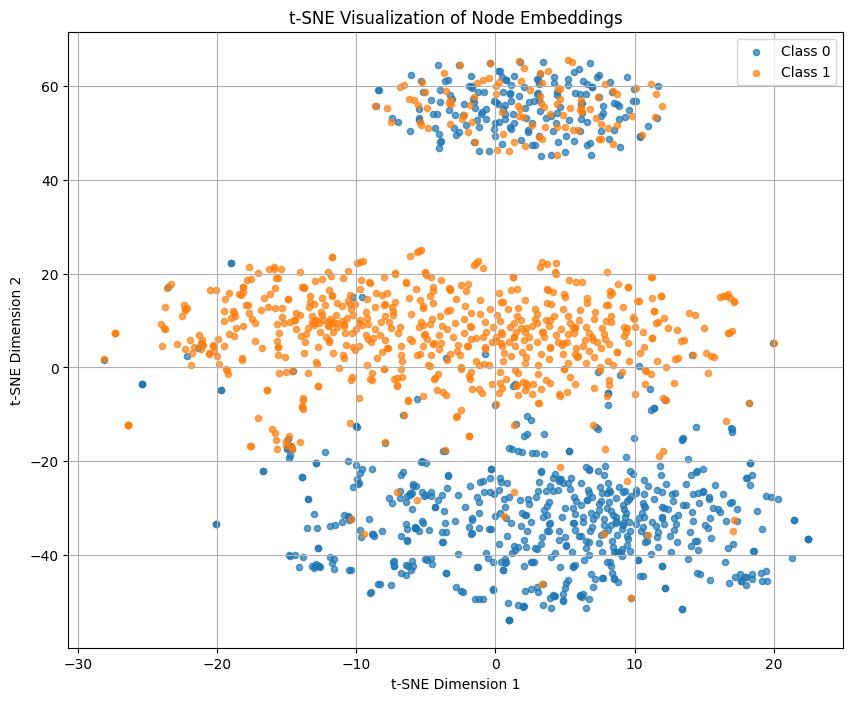

In [48]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(node_embeddings.numpy())
labels = data.y.numpy()

plt.figure(figsize=(10, 8))
for class_label in np.unique(labels):
    idx = labels == class_label
    plt.scatter(
        embeddings_2d[idx, 0],
        embeddings_2d[idx, 1],
        label=f"Class {class_label}",
        alpha=0.7,
        s=20
    )

plt.title("t-SNE Visualization of Node Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

#### Выводы

Были протестированны следующие модели:

**Node2Vec**
+ Validation Accuracy: 0.8826
+ Test Accuracy: 0.9228

**DeepWalk**
+ Validation Accuracy: 0.8826
+ Test Accuracy: 0.9195

**GIN**
+ Validation Accuracy: 0.7416
+ Test Accuracy: 0.7215

**GCN**
+ Validation Accuracy: 0.7148
+ Test Accuracy: 0.6812

**GraphSAGE**
+ Validation Accuracy: 0.5839
+ Test Accuracy: 0.5537

**GAT**
+ Validation Accuracy: 0.5067
+ Test Accuracy: 0.5101

1. **Node2Vec и DeepWalk**:
   - Обе модели превосходят остальные методы
   - **Node2Vec** имеет лучшее качество на тестовой выборке по сравнению с DeepWalk.
   - Это указывает на то, что гибкость Node2Vec (параметры `p` и `q`) лучше подходит для захвата как локальной, так и глобальной структуры графа.

2. **Graph-based Neural Networks (GCN, GAT, GIN, GraphSAGE)**:
   - Эти модели демонстрируют более низкие результаты, что может быть связано с:
     - Отсутствием признаков узлов.
     - Плохим улавливанием глобальных связей между узлами.

**DeepWalk и Node2Vec** хорошо используют глобальную информацию графа через случайные блуждания, что делает их особенно эффективными для задач, подобных PolBlogs, где классы четко разделены по структуре графа.

Визуализация эмбеддингов показывает чёткое разделение эмбеддингов классов:
- Узлы классов `0` и `1` формируют отдельные кластеры.
- Разделение классов при использовании Node2Vec кажется более чётким, что подтверждает его способность адаптироваться к структуре графа через настройку параметров (`p`, `q`).
- Вероятно, в третий кластер входят вершины без ребер.